# Vader Model approach

## Preprocessing
English rule: never two repeating characters in a word. Remove any repeating characters from words.

Algo can not use text's meta characters. Use regular expressions to eliminate them.

Lemmatize text: Return all words to their root form

Install NLTK library

https://soshace.com/unsupervised-sentiment-analysis-using-vader-and-flair/

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')  # Download the VADER lexicon
import matplotlib.pyplot as plt

import psycopg2
from sqlalchemy import create_engine

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [44]:
# import data
data = pd.read_csv('Twitter/result20160101-20170101.csv',encoding='ISO-8859-1')
# be sure to use the fixed file to the year 2016
# error: ParserError: Error tokenizing data. C error: Expected 34 fields in line 1652, saw 67

In [ ]:
# After view of data we need:
# Need: user id, date, tweet, city, state, username
# In the csv: create_at, geo_tag.stateName, user.id, text

In [45]:
# grab fields of interest
# select the columns wanted and rename them
df_selection = data[['create_at', 'geo_tag.stateName', 'user.id', 'text']]
data = df_selection.rename(columns={
    'create_at': 'Created',
    'geo_tag.stateName': 'State',
    'user.id': 'Owner',
    'text': 'Tweet'
})
data

,Created,State,Owner,Tweet
0,2016-01-01 2:56:36,Alabama,245053853,Richard Shelby holds real FTD meetings with hi...
1,2016-01-02 1:25:05,Texas,4656434324,Last election chance to rid America of the sco...
2,2016-01-02 22:17:10,Nevada,3676940660,The super-rich are spending incredible amounts...
3,2016-01-03 10:33:49,Texas,14649308,Deep convos after midtown about Black Lives Ma...
4,2016-01-04 6:59:14,Minnesota,10207502,"@GoldenCreek2608 Respectfully,how will a statu..."
...,...,...,...,...
8370,2016-11-29 5:25:46,California,8395482,So you're saying it was economic populism that...
8371,2016-11-29 11:14:18,Wyoming,57732182,Dem narrative isn't working anywhere-gun contr...
8372,2016-11-29 15:07:31,Massachusetts,755425,Im old enough to remember when Trumps genera...
8373,2016-11-29 17:11:24,Virginia,126009130,@seanhannity @newtgingrich Romney & Ryan could...


In [46]:
# convert the states to abbrivations
state_mapping = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# Apply the state mapping to convert the state column
data['State'] = data['State'].map(state_mapping)

# Print the updated DataFrame
data

,Created,State,Owner,Tweet
0,2016-01-01 2:56:36,AL,245053853,Richard Shelby holds real FTD meetings with hi...
1,2016-01-02 1:25:05,TX,4656434324,Last election chance to rid America of the sco...
2,2016-01-02 22:17:10,NV,3676940660,The super-rich are spending incredible amounts...
3,2016-01-03 10:33:49,TX,14649308,Deep convos after midtown about Black Lives Ma...
4,2016-01-04 6:59:14,MN,10207502,"@GoldenCreek2608 Respectfully,how will a statu..."
...,...,...,...,...
8370,2016-11-29 5:25:46,CA,8395482,So you're saying it was economic populism that...
8371,2016-11-29 11:14:18,WY,57732182,Dem narrative isn't working anywhere-gun contr...
8372,2016-11-29 15:07:31,MA,755425,Im old enough to remember when Trumps genera...
8373,2016-11-29 17:11:24,VA,126009130,@seanhannity @newtgingrich Romney & Ryan could...


In [47]:
# add year and office columns
data['Year'] = 2016
# Arrange columns: Move the Year and Office columns to the front
new_cols = ['Year', 'Created', 'State', 'Owner', 'Tweet']
data_2016 = data.reindex(columns=new_cols)
data_2016
# gives 8375

,Year,Created,State,Owner,Tweet
0,2016,2016-01-01 2:56:36,AL,245053853,Richard Shelby holds real FTD meetings with hi...
1,2016,2016-01-02 1:25:05,TX,4656434324,Last election chance to rid America of the sco...
2,2016,2016-01-02 22:17:10,NV,3676940660,The super-rich are spending incredible amounts...
3,2016,2016-01-03 10:33:49,TX,14649308,Deep convos after midtown about Black Lives Ma...
4,2016,2016-01-04 6:59:14,MN,10207502,"@GoldenCreek2608 Respectfully,how will a statu..."
...,...,...,...,...,...
8370,2016,2016-11-29 5:25:46,CA,8395482,So you're saying it was economic populism that...
8371,2016,2016-11-29 11:14:18,WY,57732182,Dem narrative isn't working anywhere-gun contr...
8372,2016,2016-11-29 15:07:31,MA,755425,Im old enough to remember when Trumps genera...
8373,2016,2016-11-29 17:11:24,VA,126009130,@seanhannity @newtgingrich Romney & Ryan could...


In [48]:
# Check for duplicate rows
duplicate_rows = data_2016.duplicated()

# Print the duplicate rows
print(data_2016[duplicate_rows])

      Year              Created State               Owner   
122   2016   2016-01-18 4:07:17    MA           219070080  \
173   2016  2016-02-02 20:10:22    MO          2493487567   
307   2016  2016-02-02 20:10:22    MO          2493487567   
316   2016  2016-02-04 17:36:46    MN           529556135   
317   2016  2016-02-04 20:02:11    FL           132553024   
...    ...                  ...   ...                 ...   
8180  2016  2016-11-18 20:23:00    CA            23172657   
8260  2016   2016-11-23 1:18:41    MI           537428086   
8281  2016  2016-11-23 20:13:16    NY           276529582   
8299  2016  2016-11-25 14:36:04    IL  707576396298649600   
8303  2016  2016-11-25 18:20:53    CA          1584035035   

                                                  Tweet  
122   @gabbimcdaniel Yeah, I feel the same about #SC...  
173   #illegalimmigration #openborders and #rapefuge...  
307   #illegalimmigration #openborders and #rapefuge...  
316   This election we need #openbo

In [49]:
# Remove duplicate rows
data_2016 = data_2016.drop_duplicates()

# Print the DataFrame without duplicates
data_2016
# gives 8199 rows

,Year,Created,State,Owner,Tweet
0,2016,2016-01-01 2:56:36,AL,245053853,Richard Shelby holds real FTD meetings with hi...
1,2016,2016-01-02 1:25:05,TX,4656434324,Last election chance to rid America of the sco...
2,2016,2016-01-02 22:17:10,NV,3676940660,The super-rich are spending incredible amounts...
3,2016,2016-01-03 10:33:49,TX,14649308,Deep convos after midtown about Black Lives Ma...
4,2016,2016-01-04 6:59:14,MN,10207502,"@GoldenCreek2608 Respectfully,how will a statu..."
...,...,...,...,...,...
8370,2016,2016-11-29 5:25:46,CA,8395482,So you're saying it was economic populism that...
8371,2016,2016-11-29 11:14:18,WY,57732182,Dem narrative isn't working anywhere-gun contr...
8372,2016,2016-11-29 15:07:31,MA,755425,Im old enough to remember when Trumps genera...
8373,2016,2016-11-29 17:11:24,VA,126009130,@seanhannity @newtgingrich Romney & Ryan could...


### Clean, preprocess, check for empty strings

In [50]:
def trim_length(text):
    '''
    This method removes the repeating characters that are repeated more than 2 times
    '''
    pat = re.compile(r"(.)\1{2,}")
    return pat.sub(r"\1\1", text)

def word_correct(myStr):
    '''
    This method accepts a string and removes the meta characters from it
    '''
    myStr = str(myStr)
    pat = re.compile(r'[^a-zA-Z1-9]+')
    corrected_str = ''
    splits = myStr.split()
    for word in splits:
        word = word.strip()
        word = re.sub(pat, '', word).lower()
        word = trim_length(word)
        corrected_str = corrected_str+word+' '
    corrected_str = corrected_str.strip()
    return corrected_str

def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_word(myStr):
    myStr = str(myStr)
    lemmatizer = WordNetLemmatizer()
    lst_word = nltk.word_tokenize(myStr)
    final_str=''
    for word in lst_word:
        word = lemmatizer.lemmatize(word, get_pos(word))
        final_str = final_str+word+' '

    final_str = final_str.strip()
    return final_str

data_2016['Tweet'] = data_2016['Tweet'].apply(lambda i:word_correct(i))
data_2016['Tweet'] = data_2016['Tweet'].apply(lambda i:lemmatize_word(i))
print('Done')

C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\3447730354.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2016['Tweet'] = data_2016['Tweet'].apply(lambda i:word_correct(i))


Done


C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\3447730354.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2016['Tweet'] = data_2016['Tweet'].apply(lambda i:lemmatize_word(i))


In [51]:
data_2016

,Year,Created,State,Owner,Tweet
0,2016,2016-01-01 2:56:36,AL,245053853,richard shelby hold real ftd meeting with his ...
1,2016,2016-01-02 1:25:05,TX,4656434324,last election chance to rid america of the sco...
2,2016,2016-01-02 22:17:10,NV,3676940660,the superrich be spending incredible amount on...
3,2016,2016-01-03 10:33:49,TX,14649308,deep convos after midtown about black life mat...
4,2016,2016-01-04 6:59:14,MN,10207502,goldencreek268 respectfullyhow will a status q...
...,...,...,...,...,...
8370,2016,2016-11-29 5:25:46,CA,8395482,so youre say it be economic populism that won ...
8371,2016,2016-11-29 11:14:18,WY,57732182,dem narrative isnt work anywheregun controlsom...
8372,2016,2016-11-29 15:07:31,MA,755425,im old enough to remember when trump generalel...
8373,2016,2016-11-29 17:11:24,VA,126009130,seanhannity newtgingrich romney ryan couldnt w...


### Isolate sentiment scores from text data

### Locate tweet by bias subject
abortion, planned parenthood, pro-choice  
immigration, refugees, border, undocumented, nationalism, xenophobia, dreamers, asylum seekers  
race, white privilege, racial discrimination, BLM, black lives matter  
"socioeconomic", "poverty line", "working class", "middle class", "medicare"  

In [52]:
def extract_abortion_text(df):
    df['Abortion'] = df['Tweet'].str.extract(r'(\b(?:abortion|planned|parenthood|prochoice|pro-choice|prolife|pro-life|reproductiverights|reproductive-rights|right|choose|women\'s|rights|termination|roe|wade|pro-abortion|anti-abortion|fetus|pregnancy|reproductive|healthcare|health|access|ban|debate)\b)', flags=re.IGNORECASE)
    return df

abortion_tweet_2016 = extract_abortion_text(data_2016)
abortion_tweet_2016

C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\525130802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Abortion'] = df['Tweet'].str.extract(r'(\b(?:abortion|planned|parenthood|prochoice|pro-choice|prolife|pro-life|reproductiverights|reproductive-rights|right|choose|women\'s|rights|termination|roe|wade|pro-abortion|anti-abortion|fetus|pregnancy|reproductive|healthcare|health|access|ban|debate)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion
0,2016,2016-01-01 2:56:36,AL,245053853,richard shelby hold real ftd meeting with his ...,NaN
1,2016,2016-01-02 1:25:05,TX,4656434324,last election chance to rid america of the sco...,NaN
2,2016,2016-01-02 22:17:10,NV,3676940660,the superrich be spending incredible amount on...,NaN
3,2016,2016-01-03 10:33:49,TX,14649308,deep convos after midtown about black life mat...,NaN
4,2016,2016-01-04 6:59:14,MN,10207502,goldencreek268 respectfullyhow will a status q...,NaN
...,...,...,...,...,...,...
8370,2016,2016-11-29 5:25:46,CA,8395482,so youre say it be economic populism that won ...,NaN
8371,2016,2016-11-29 11:14:18,WY,57732182,dem narrative isnt work anywheregun controlsom...,NaN
8372,2016,2016-11-29 15:07:31,MA,755425,im old enough to remember when trump generalel...,NaN
8373,2016,2016-11-29 17:11:24,VA,126009130,seanhannity newtgingrich romney ryan couldnt w...,NaN


In [53]:
# remove NaN rows
abortion_2016 = abortion_tweet_2016[abortion_tweet_2016['Abortion'].notna()]
abortion_2016
# gives 585 rows

,Year,Created,State,Owner,Tweet,Abortion
9,2016,2016-01-06 15:27:19,NY,49698134,sound like the gop establishment have decide t...,abortion
16,2016,2016-01-10 14:16:18,MA,395484842,jebbush be in south carolina yesterday attend ...,prolife
41,2016,2016-01-18 4:07:17,MA,219070080,gabbimcdaniel yeah i feel the same about scotu...,reproductive
47,2016,2016-01-19 16:45:39,LA,3310873058,for the uk to consider ban someone who make a ...,ban
53,2016,2016-01-21 0:28:25,VA,413470255,thegardner97 djgreenwald in last election cycl...,abortion
...,...,...,...,...,...,...
8294,2016,2016-11-25 2:30:50,UT,472606666,kindafedup jilevin hustonwrites and we wouldnt...,abortion
8300,2016,2016-11-25 15:00:08,WA,2601058635,firefly426 if this be re the election i awoke ...,debate
8302,2016,2016-11-25 18:02:18,OH,2569710959,a post election job organize to protect health...,healthcare
8305,2016,2016-11-25 18:57:46,FL,100800329,my mom smell weed on south beach i cant wait t...,right


### Feed cleaned data into VADER algo
Gives data point count of positive and negative labels

The SentimentIntensityAnalyzer() function returns four sentiment scores: positive (pos), negative (neg), neutral (neu), and compound (compound). Here's a brief explanation of each score:

Positive (pos): This score represents the intensity or strength of positive sentiment in a given text. It indicates the extent to which the text expresses positive emotions or opinions.

Negative (neg): This score represents the intensity or strength of negative sentiment in a given text. It indicates the extent to which the text expresses negative emotions or opinions.

Neutral (neu): This score represents the intensity or strength of neutral sentiment in a given text. It indicates the extent to which the text is neutral or lacks strong positive or negative sentiment.

Compound (compound): The compound score is a combination of the positive, negative, and neutral scores, providing an overall sentiment polarity of the text. It is a normalized score that ranges from -1 to 1, where -1 represents extremely negative sentiment, 1 represents extremely positive sentiment, and 0 represents neutral sentiment.

When to use all four sentiment scores (pos, neg, neu, compound) or just positive and negative depends on the specific analysis and context:

If you need a comprehensive understanding of the sentiment expressed in the text, including the strength of positive, negative, and neutral sentiments, then it is appropriate to use all four scores.

If you are interested in capturing the overall sentiment polarity of the text in a single value, you can use the compound score. The compound score takes into account the combined effect of positive and negative sentiments and provides an overall sentiment measure. This can be useful for comparative analysis or summarizing sentiment across multiple texts.

However, if you are primarily focused on the distinction between positive and negative sentiment and not concerned with neutral sentiment, you can use only the positive and negative scores.

If you are interested in investigating the effect of overall sentiment (i.e., both positive and negative sentiment), then you should keep all sentiment scores. However, if you are only interested in the effect of negative sentiment on election outcomes, for example, then you might want to focus only on the negative sentiment scores and disregard the neutral and positive scores.

It's also important to consider the potential impact of the neutral and compound sentiment scores on your analysis. For example, if most of the sentiment scores are neutral, then the positive and negative scores may not provide much useful information. In this case, it might make sense to exclude the neutral scores from your analysis. However, if there is a significant amount of variation in the neutral scores, then including them in your analysis could provide important insights.

Possible Hypothesis:   
Higher negative sentiment scores of a bias topic gives higher election count for Republican candidates over time.  

Election Count: The normalized election counts by year, state, and party. This will serve as your dependent variable, representing the election outcomes.

Negative Sentiment Scores: The negative sentiment scores associated with the bias topic of interest (e.g., abortion) from your sentiment analysis. These scores indicate the degree of negative sentiment expressed in the articles or tweets. You can aggregate these scores by year, state, and bias topic.

Republican Party Affiliation: A categorical variable indicating whether a candidate is affiliated with the Republican party. This variable will be used as your independent variable.  

By examining the relationship between the negative sentiment scores and the election count while controlling for the Republican party affiliation, you can assess whether higher negative sentiment scores of the bias topic are associated with a higher election count for Republican candidates over time.

## Using only positive and negative sentiment scores
Using only positive and negative sentiment scores is different from using the compound sentiment score as it focuses solely on the polarity of sentiment (positive or negative) without considering the neutral sentiment. Here's a breakdown of the differences:

Positive and Negative Sentiment Scores:

Positive and negative sentiment scores provide separate measures of the intensity or strength of positive and negative sentiments in a given text.
Positive sentiment score indicates the extent to which the text expresses positive emotions or opinions.
Negative sentiment score indicates the extent to which the text expresses negative emotions or opinions.
These scores allow you to analyze and compare the presence and intensity of positive and negative sentiment separately.
Compound Sentiment Score:

The compound sentiment score is a single, normalized score that combines the positive, negative, and neutral sentiment scores into an overall polarity measure.
It represents the overall sentiment polarity of the text, taking into account the combined effect of positive and negative sentiments.
The compound score ranges from -1 to 1, where -1 indicates extremely negative sentiment, 1 indicates extremely positive sentiment, and 0 indicates neutral sentiment.
This score provides a holistic measure of sentiment that summarizes the overall sentiment expressed in the text.
When to use one over the other:

Use Positive and Negative Sentiment Scores:

When you are interested in analyzing and comparing the intensity or strength of positive and negative sentiments separately.
When you want to understand the specific positive and negative emotions or opinions expressed in the text.
When you need to explore how positive and negative sentiment relate to different factors or variables in your analysis.
Use Compound Sentiment Score:

When you want to get a single, overall measure of sentiment polarity for the text.
When you need a summarized sentiment value that takes into account the combined effect of positive and negative sentiments.
When you want to compare the sentiment polarity across multiple texts or perform high-level sentiment analysis without focusing on specific positive or negative emotions.
The choice between using only positive and negative sentiment scores or the compound sentiment score depends on the specific requirements of your analysis and the insights you aim to derive. Consider the level of detail and the overall sentiment measure that aligns with your research objectives or use case.

In [55]:
def get_sentiment_scores(df):
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
        # Create a new column for sentiment scores
    df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
    
    # Remove the 'neu' and 'compound' columns from the SentimentScores column
    df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})
    
    return df

In [56]:
# Call sentiment function
abortion_sent_2016 = get_sentiment_scores(abortion_2016)
abortion_sent_2016

C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\172291821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\172291821.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})


,Year,Created,State,Owner,Tweet,Abortion,SentimentScores
9,2016,2016-01-06 15:27:19,NY,49698134,sound like the gop establishment have decide t...,abortion,"{'neg': 0.0, 'pos': 0.128}"
16,2016,2016-01-10 14:16:18,MA,395484842,jebbush be in south carolina yesterday attend ...,prolife,"{'neg': 0.07, 'pos': 0.0}"
41,2016,2016-01-18 4:07:17,MA,219070080,gabbimcdaniel yeah i feel the same about scotu...,reproductive,"{'neg': 0.0, 'pos': 0.209}"
47,2016,2016-01-19 16:45:39,LA,3310873058,for the uk to consider ban someone who make a ...,ban,"{'neg': 0.277, 'pos': 0.0}"
53,2016,2016-01-21 0:28:25,VA,413470255,thegardner97 djgreenwald in last election cycl...,abortion,"{'neg': 0.109, 'pos': 0.122}"
...,...,...,...,...,...,...,...
8294,2016,2016-11-25 2:30:50,UT,472606666,kindafedup jilevin hustonwrites and we wouldnt...,abortion,"{'neg': 0.0, 'pos': 0.135}"
8300,2016,2016-11-25 15:00:08,WA,2601058635,firefly426 if this be re the election i awoke ...,debate,"{'neg': 0.0, 'pos': 0.0}"
8302,2016,2016-11-25 18:02:18,OH,2569710959,a post election job organize to protect health...,healthcare,"{'neg': 0.084, 'pos': 0.233}"
8305,2016,2016-11-25 18:57:46,FL,100800329,my mom smell weed on south beach i cant wait t...,right,"{'neg': 0.0, 'pos': 0.18}"


In [57]:
# show values
abortion_sent_2016['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        129
{'neg': 0.0, 'pos': 0.244}        6
{'neg': 0.0, 'pos': 0.115}        4
{'neg': 0.163, 'pos': 0.0}        4
{'neg': 0.0, 'pos': 0.112}        4
                               ... 
{'neg': 0.113, 'pos': 0.085}      1
{'neg': 0.362, 'pos': 0.0}        1
{'neg': 0.195, 'pos': 0.0}        1
{'neg': 0.097, 'pos': 0.0}        1
{'neg': 0.242, 'pos': 0.217}      1
Name: count, Length: 392, dtype: int64

In [58]:
# Extract the sentiment scores from the 'SentimentScores' column
abortion_sent_2016['Norm_Neg'] = abortion_sent_2016['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
abortion_sent_2016['Norm_Pos'] = abortion_sent_2016['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
abortion_sent_2016

C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\920131369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abortion_sent_2016['Norm_Neg'] = abortion_sent_2016['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\920131369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abortion_sent_2016['Norm_Pos'] = abortion_sent_2016['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg

,Year,Created,State,Owner,Tweet,Abortion,SentimentScores,Norm_Neg,Norm_Pos
9,2016,2016-01-06 15:27:19,NY,49698134,sound like the gop establishment have decide t...,abortion,"{'neg': 0.0, 'pos': 0.128}",0.000000,1.000000
16,2016,2016-01-10 14:16:18,MA,395484842,jebbush be in south carolina yesterday attend ...,prolife,"{'neg': 0.07, 'pos': 0.0}",1.000000,0.000000
41,2016,2016-01-18 4:07:17,MA,219070080,gabbimcdaniel yeah i feel the same about scotu...,reproductive,"{'neg': 0.0, 'pos': 0.209}",0.000000,1.000000
47,2016,2016-01-19 16:45:39,LA,3310873058,for the uk to consider ban someone who make a ...,ban,"{'neg': 0.277, 'pos': 0.0}",1.000000,0.000000
53,2016,2016-01-21 0:28:25,VA,413470255,thegardner97 djgreenwald in last election cycl...,abortion,"{'neg': 0.109, 'pos': 0.122}",0.471861,0.528139
...,...,...,...,...,...,...,...,...,...
8294,2016,2016-11-25 2:30:50,UT,472606666,kindafedup jilevin hustonwrites and we wouldnt...,abortion,"{'neg': 0.0, 'pos': 0.135}",0.000000,1.000000
8300,2016,2016-11-25 15:00:08,WA,2601058635,firefly426 if this be re the election i awoke ...,debate,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
8302,2016,2016-11-25 18:02:18,OH,2569710959,a post election job organize to protect health...,healthcare,"{'neg': 0.084, 'pos': 0.233}",0.264984,0.735016
8305,2016,2016-11-25 18:57:46,FL,100800329,my mom smell weed on south beach i cant wait t...,right,"{'neg': 0.0, 'pos': 0.18}",0.000000,1.000000


# Analyze Sentiment Scores

In [59]:
# Count the number of positive and negative tweets
num_positive_tweets = abortion_sent_2016['Norm_Pos'].sum()
num_negative_tweets = abortion_sent_2016['Norm_Neg'].sum()

# Print the results
print("Number of positive abortion tweets:", num_positive_tweets)
print("Number of negative abortion tweets:", num_negative_tweets)


Number of positive abortion tweets: 224.6682878657718
Number of negative abortion tweets: 231.33171213422818


In [60]:
# Calculate the percentage of positive and negative tweets
total_tweets = len(abortion_sent_2016)
percent_positive_tweets = (num_positive_tweets / total_tweets) * 100
percent_negative_tweets = (num_negative_tweets / total_tweets) * 100

# Print the results
print("Percentage of abortion positive tweets:", percent_positive_tweets)
print("Percentage of abortion negative tweets:", percent_negative_tweets)


Percentage of abortion positive tweets: 38.40483553261056
Percentage of abortion negative tweets: 39.54388241610739


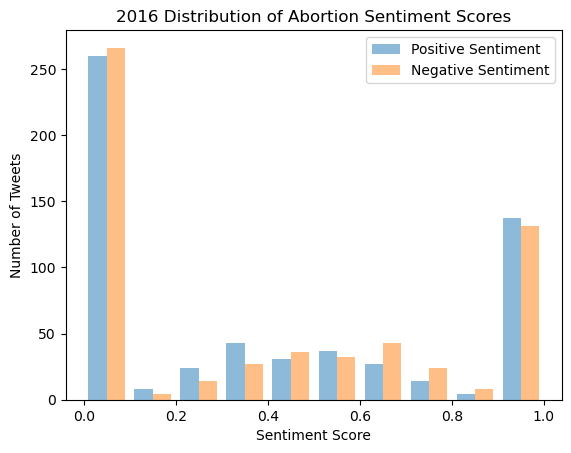

In [61]:
# import matplotlib.pyplot as plt

# Create a histogram of sentiment scores with side-by-side bars
plt.hist([abortion_sent_2016['Norm_Pos'], abortion_sent_2016['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])

# Set labels and title
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Tweets')
plt.title('2016 Distribution of Abortion Sentiment Scores')

# Add legend
plt.legend()

# Show the plot
plt.show()


# An Idea: 
### Creating one table with all Bias group tags
The single table that holds everything is built from the individual tables

# Race Tweets

In [62]:
def extract_race_text(df):
    df['Race'] = df['Tweet'].str.extract(r'(\b(?:racism|discrimination|equality|racial|ethnic|bias|prejudice|injustice|diversity|race|white|privilege|BLM|black|lives|matter|systemic|social|justice|sterotype|oppression|minority|segregation|multiculturalism|colorism|civil|rights|profiling|cultrual|appropriation|affirmative|action|intersectionality|institutional|discrimination|implicit)\b)', flags=re.IGNORECASE) 
    return df

# call race function
# note data_2016 will hold all columns with NaN's
race_tweet_2016 = extract_race_text(data_2016)
race_tweet_2016

C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\3974130501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Race'] = df['Tweet'].str.extract(r'(\b(?:racism|discrimination|equality|racial|ethnic|bias|prejudice|injustice|diversity|race|white|privilege|BLM|black|lives|matter|systemic|social|justice|sterotype|oppression|minority|segregation|multiculturalism|colorism|civil|rights|profiling|cultrual|appropriation|affirmative|action|intersectionality|institutional|discrimination|implicit)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race
0,2016,2016-01-01 2:56:36,AL,245053853,richard shelby hold real ftd meeting with his ...,NaN,NaN
1,2016,2016-01-02 1:25:05,TX,4656434324,last election chance to rid america of the sco...,NaN,NaN
2,2016,2016-01-02 22:17:10,NV,3676940660,the superrich be spending incredible amount on...,NaN,NaN
3,2016,2016-01-03 10:33:49,TX,14649308,deep convos after midtown about black life mat...,NaN,black
4,2016,2016-01-04 6:59:14,MN,10207502,goldencreek268 respectfullyhow will a status q...,NaN,NaN
...,...,...,...,...,...,...,...
8370,2016,2016-11-29 5:25:46,CA,8395482,so youre say it be economic populism that won ...,NaN,white
8371,2016,2016-11-29 11:14:18,WY,57732182,dem narrative isnt work anywheregun controlsom...,NaN,NaN
8372,2016,2016-11-29 15:07:31,MA,755425,im old enough to remember when trump generalel...,NaN,NaN
8373,2016,2016-11-29 17:11:24,VA,126009130,seanhannity newtgingrich romney ryan couldnt w...,NaN,NaN


In [63]:
race_2016 = race_tweet_2016[race_tweet_2016['Race'].notna()]
# Drop Abortion column
race_2016 = race_2016.drop('Abortion', axis=1)
race_2016
# gives 1087 rows

,Year,Created,State,Owner,Tweet,Race
3,2016,2016-01-03 10:33:49,TX,14649308,deep convos after midtown about black life mat...,black
15,2016,2016-01-10 2:59:01,FL,198305999,hard to prove personal damage except the ppl s...,white
19,2016,2016-01-12 1:11:48,TX,4340454980,if h win the election there will a civil war i...,civil
57,2016,2016-01-22 16:13:37,NY,624032308,perhaps this election cycle be prove that max ...,racial
59,2016,2016-01-23 4:00:16,NY,484002052,dont even wan na vote in the election bc every...,white
...,...,...,...,...,...,...
8343,2016,2016-11-27 19:33:50,NV,515101154,toni morrison fear of lose white privilege lea...,white
8351,2016,2016-11-27 22:39:22,CA,44959505,toni morrison fear of lose white privilege lea...,white
8352,2016,2016-11-27 23:25:18,VA,1576493125,on nbc news discuss racial backlash and intimi...,racial
8367,2016,2016-11-28 23:51:09,TX,408110696,so how do you steer kid in a first grade class...,racial


In [64]:
# run Vader sentiment on race tweets
race_sent_2016 = get_sentiment_scores(race_2016)
race_sent_2016

,Year,Created,State,Owner,Tweet,Race,SentimentScores
3,2016,2016-01-03 10:33:49,TX,14649308,deep convos after midtown about black life mat...,black,"{'neg': 0.26, 'pos': 0.073}"
15,2016,2016-01-10 2:59:01,FL,198305999,hard to prove personal damage except the ppl s...,white,"{'neg': 0.435, 'pos': 0.0}"
19,2016,2016-01-12 1:11:48,TX,4340454980,if h win the election there will a civil war i...,civil,"{'neg': 0.204, 'pos': 0.207}"
57,2016,2016-01-22 16:13:37,NY,624032308,perhaps this election cycle be prove that max ...,racial,"{'neg': 0.0, 'pos': 0.0}"
59,2016,2016-01-23 4:00:16,NY,484002052,dont even wan na vote in the election bc every...,white,"{'neg': 0.162, 'pos': 0.171}"
...,...,...,...,...,...,...,...
8343,2016,2016-11-27 19:33:50,NV,515101154,toni morrison fear of lose white privilege lea...,white,"{'neg': 0.339, 'pos': 0.144}"
8351,2016,2016-11-27 22:39:22,CA,44959505,toni morrison fear of lose white privilege lea...,white,"{'neg': 0.304, 'pos': 0.129}"
8352,2016,2016-11-27 23:25:18,VA,1576493125,on nbc news discuss racial backlash and intimi...,racial,"{'neg': 0.106, 'pos': 0.14}"
8367,2016,2016-11-28 23:51:09,TX,408110696,so how do you steer kid in a first grade class...,racial,"{'neg': 0.107, 'pos': 0.0}"


In [65]:
# count race sentiment scores
race_2016['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        105
{'neg': 0.0, 'pos': 0.303}       30
{'neg': 0.304, 'pos': 0.129}     14
{'neg': 0.343, 'pos': 0.0}       10
{'neg': 0.0, 'pos': 0.091}        6
                               ... 
{'neg': 0.35, 'pos': 0.12}        1
{'neg': 0.099, 'pos': 0.0}        1
{'neg': 0.147, 'pos': 0.049}      1
{'neg': 0.0, 'pos': 0.355}        1
{'neg': 0.106, 'pos': 0.14}       1
Name: count, Length: 749, dtype: int64

In [66]:
# Extract the sentiment scores from the 'SentimentScores' column
race_sent_2016['Norm_Neg'] = race_sent_2016['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
race_sent_2016['Norm_Pos'] = race_sent_2016['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
race_sent_2016.head()

,Year,Created,State,Owner,Tweet,Race,SentimentScores,Norm_Neg,Norm_Pos
3,2016,2016-01-03 10:33:49,TX,14649308,deep convos after midtown about black life mat...,black,"{'neg': 0.26, 'pos': 0.073}",0.780781,0.219219
15,2016,2016-01-10 2:59:01,FL,198305999,hard to prove personal damage except the ppl s...,white,"{'neg': 0.435, 'pos': 0.0}",1.000000,0.000000
19,2016,2016-01-12 1:11:48,TX,4340454980,if h win the election there will a civil war i...,civil,"{'neg': 0.204, 'pos': 0.207}",0.496350,0.503650
57,2016,2016-01-22 16:13:37,NY,624032308,perhaps this election cycle be prove that max ...,racial,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
59,2016,2016-01-23 4:00:16,NY,484002052,dont even wan na vote in the election bc every...,white,"{'neg': 0.162, 'pos': 0.171}",0.486486,0.513514


# Immigration Tweets

In [67]:
def extract_immigration_text(df):
    df['Immigration'] = df['Tweet'].str.extract(r'(\b(?:immigration|refugees|border|undocumented|nationalism|xenophobia|dreamers|asylum|seekers|migration|deportation|citizenship|control|illegal|policy|reform|visa|integration|assimilation|sanctuary|family|separation|humanitarian|immigrant|rights|gloal|migration)\b)', flags=re.IGNORECASE)
    return df

immigration_tweet_2016 = extract_immigration_text(data_2016)
immigration_tweet_2016

C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\2777675109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Immigration'] = df['Tweet'].str.extract(r'(\b(?:immigration|refugees|border|undocumented|nationalism|xenophobia|dreamers|asylum|seekers|migration|deportation|citizenship|control|illegal|policy|reform|visa|integration|assimilation|sanctuary|family|separation|humanitarian|immigrant|rights|gloal|migration)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration
0,2016,2016-01-01 2:56:36,AL,245053853,richard shelby hold real ftd meeting with his ...,NaN,NaN,NaN
1,2016,2016-01-02 1:25:05,TX,4656434324,last election chance to rid america of the sco...,NaN,NaN,NaN
2,2016,2016-01-02 22:17:10,NV,3676940660,the superrich be spending incredible amount on...,NaN,NaN,NaN
3,2016,2016-01-03 10:33:49,TX,14649308,deep convos after midtown about black life mat...,NaN,black,NaN
4,2016,2016-01-04 6:59:14,MN,10207502,goldencreek268 respectfullyhow will a status q...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
8370,2016,2016-11-29 5:25:46,CA,8395482,so youre say it be economic populism that won ...,NaN,white,nationalism
8371,2016,2016-11-29 11:14:18,WY,57732182,dem narrative isnt work anywheregun controlsom...,NaN,NaN,NaN
8372,2016,2016-11-29 15:07:31,MA,755425,im old enough to remember when trump generalel...,NaN,NaN,NaN
8373,2016,2016-11-29 17:11:24,VA,126009130,seanhannity newtgingrich romney ryan couldnt w...,NaN,NaN,NaN


In [68]:
immigration_2016 = immigration_tweet_2016[immigration_tweet_2016['Immigration'].notna()]
# Drop Abortion and Race columns
immigration_2016 = immigration_2016.drop(['Abortion', 'Race'], axis=1)
immigration_2016
# gives 1301 rows


,Year,Created,State,Owner,Tweet,Immigration
8,2016,2016-01-06 2:52:22,AZ,67238855,usatoday bo i hear you refer to electionobama ...,immigration
13,2016,2016-01-09 3:39:33,AZ,67238855,newsweek bo i hear you refer to electionobama ...,immigration
14,2016,2016-01-09 16:29:29,AZ,67238855,bo say i hear you refer to electionobama immig...,immigration
21,2016,2016-01-12 17:01:13,CA,15859894,a controversial american pork growth drug be c...,border
34,2016,2016-01-15 21:27:45,NY,280477655,look issue realdonaldtrump have brought up thi...,illegal
...,...,...,...,...,...,...
8359,2016,2016-11-28 15:17:22,NY,2927349619,hundred of church offer sanctuary to undocumen...,sanctuary
8365,2016,2016-11-28 21:17:17,MO,787479013912514560,xenophobia be the wordoftheyear from httpstcob...,xenophobia
8366,2016,2016-11-28 21:49:25,AZ,67238855,postpolitics bo i hear you refer to election i...,immigration
8369,2016,2016-11-29 3:58:07,CA,44526609,bcappelbaum richardflorida russia hack million...,illegal


In [69]:
# run Vader sentiment on immigration tweets
immigration_sent_2016 = get_sentiment_scores(immigration_2016)
immigration_sent_2016

,Year,Created,State,Owner,Tweet,Immigration,SentimentScores
8,2016,2016-01-06 2:52:22,AZ,67238855,usatoday bo i hear you refer to electionobama ...,immigration,"{'neg': 0.158, 'pos': 0.0}"
13,2016,2016-01-09 3:39:33,AZ,67238855,newsweek bo i hear you refer to electionobama ...,immigration,"{'neg': 0.158, 'pos': 0.0}"
14,2016,2016-01-09 16:29:29,AZ,67238855,bo say i hear you refer to electionobama immig...,immigration,"{'neg': 0.151, 'pos': 0.0}"
21,2016,2016-01-12 17:01:13,CA,15859894,a controversial american pork growth drug be c...,border,"{'neg': 0.11, 'pos': 0.159}"
34,2016,2016-01-15 21:27:45,NY,280477655,look issue realdonaldtrump have brought up thi...,illegal,"{'neg': 0.339, 'pos': 0.0}"
...,...,...,...,...,...,...,...
8359,2016,2016-11-28 15:17:22,NY,2927349619,hundred of church offer sanctuary to undocumen...,sanctuary,"{'neg': 0.0, 'pos': 0.0}"
8365,2016,2016-11-28 21:17:17,MO,787479013912514560,xenophobia be the wordoftheyear from httpstcob...,xenophobia,"{'neg': 0.0, 'pos': 0.162}"
8366,2016,2016-11-28 21:49:25,AZ,67238855,postpolitics bo i hear you refer to election i...,immigration,"{'neg': 0.158, 'pos': 0.0}"
8369,2016,2016-11-29 3:58:07,CA,44526609,bcappelbaum richardflorida russia hack million...,illegal,"{'neg': 0.275, 'pos': 0.0}"


In [70]:
# count immigration sentiment scores
immigration_sent_2016['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        257
{'neg': 0.158, 'pos': 0.0}       29
{'neg': 0.151, 'pos': 0.0}       16
{'neg': 0.381, 'pos': 0.0}       11
{'neg': 0.07, 'pos': 0.0}        10
                               ... 
{'neg': 0.114, 'pos': 0.205}      1
{'neg': 0.0, 'pos': 0.414}        1
{'neg': 0.0, 'pos': 0.388}        1
{'neg': 0.411, 'pos': 0.095}      1
{'neg': 0.128, 'pos': 0.0}        1
Name: count, Length: 678, dtype: int64

In [71]:
# Extract the sentiment scores from the 'SentimentScores' column
immigration_sent_2016['Norm_Neg'] = immigration_sent_2016['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
immigration_sent_2016['Norm_Pos'] = immigration_sent_2016['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
immigration_sent_2016.head()

,Year,Created,State,Owner,Tweet,Immigration,SentimentScores,Norm_Neg,Norm_Pos
8,2016,2016-01-06 2:52:22,AZ,67238855,usatoday bo i hear you refer to electionobama ...,immigration,"{'neg': 0.158, 'pos': 0.0}",1.000000,0.000000
13,2016,2016-01-09 3:39:33,AZ,67238855,newsweek bo i hear you refer to electionobama ...,immigration,"{'neg': 0.158, 'pos': 0.0}",1.000000,0.000000
14,2016,2016-01-09 16:29:29,AZ,67238855,bo say i hear you refer to electionobama immig...,immigration,"{'neg': 0.151, 'pos': 0.0}",1.000000,0.000000
21,2016,2016-01-12 17:01:13,CA,15859894,a controversial american pork growth drug be c...,border,"{'neg': 0.11, 'pos': 0.159}",0.408922,0.591078
34,2016,2016-01-15 21:27:45,NY,280477655,look issue realdonaldtrump have brought up thi...,illegal,"{'neg': 0.339, 'pos': 0.0}",1.000000,0.000000


# Socioeconomic Tweets

In [72]:
def extract_socio_text(df):
    df['Socio_Eco'] = df['Tweet'].str.extract(r'(\b(?:socioeconomic|poverty|line|working|class|middle|class|medicare|income|inequality|wealth|gap|social|justice|economic|disparities|wage|stagenation|unemployment|minimum|wage|job|security|labor|rights|affordable|housing|education|access|healthcare|affordability|social|safety|net|redistriution|mobility)\b)', flags=re.IGNORECASE)
    return df

socio_tweet_2016 = extract_socio_text(data_2016)
socio_tweet_2016

C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\2486278228.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Socio_Eco'] = df['Tweet'].str.extract(r'(\b(?:socioeconomic|poverty|line|working|class|middle|class|medicare|income|inequality|wealth|gap|social|justice|economic|disparities|wage|stagenation|unemployment|minimum|wage|job|security|labor|rights|affordable|housing|education|access|healthcare|affordability|social|safety|net|redistriution|mobility)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco
0,2016,2016-01-01 2:56:36,AL,245053853,richard shelby hold real ftd meeting with his ...,NaN,NaN,NaN,NaN
1,2016,2016-01-02 1:25:05,TX,4656434324,last election chance to rid america of the sco...,NaN,NaN,NaN,NaN
2,2016,2016-01-02 22:17:10,NV,3676940660,the superrich be spending incredible amount on...,NaN,NaN,NaN,NaN
3,2016,2016-01-03 10:33:49,TX,14649308,deep convos after midtown about black life mat...,NaN,black,NaN,NaN
4,2016,2016-01-04 6:59:14,MN,10207502,goldencreek268 respectfullyhow will a status q...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8370,2016,2016-11-29 5:25:46,CA,8395482,so youre say it be economic populism that won ...,NaN,white,nationalism,economic
8371,2016,2016-11-29 11:14:18,WY,57732182,dem narrative isnt work anywheregun controlsom...,NaN,NaN,NaN,NaN
8372,2016,2016-11-29 15:07:31,MA,755425,im old enough to remember when trump generalel...,NaN,NaN,NaN,NaN
8373,2016,2016-11-29 17:11:24,VA,126009130,seanhannity newtgingrich romney ryan couldnt w...,NaN,NaN,NaN,NaN


In [73]:
# drop NaN's
socio_2016 = socio_tweet_2016[socio_tweet_2016['Socio_Eco'].notna()]
# Drop Abortion and Race columns
socio_2016 = socio_2016.drop(['Abortion', 'Race','Immigration'], axis=1)
socio_2016
# # gives 778 rows

,Year,Created,State,Owner,Tweet,Socio_Eco
5,2016,2016-01-04 16:23:26,NH,88940328,president bill clinton say this election will ...,middle
6,2016,2016-01-05 7:13:04,VA,359716229,we need someone to videotape trump talk shit a...,middle
17,2016,2016-01-10 21:20:20,IN,1610440968,216 brings our most important election will s ...,medicare
28,2016,2016-01-14 17:45:04,AL,376303801,volunteer for senator richard shelbys reelecti...,class
68,2016,2016-01-27 12:44:09,TX,1472542232,the border really that thing hasnt work for de...,security
...,...,...,...,...,...,...
8327,2016,2016-11-26 21:58:58,CA,2826806322,i dont understand how elect a crooked billiona...,class
8330,2016,2016-11-27 0:21:13,CA,394470787,we be more concerned about security and immigr...,security
8367,2016,2016-11-28 23:51:09,TX,408110696,so how do you steer kid in a first grade class...,inequality
8370,2016,2016-11-29 5:25:46,CA,8395482,so youre say it be economic populism that won ...,economic


In [74]:
# run Vader sentiment on Socio_eco tweets
socio_sent_2016 = get_sentiment_scores(socio_2016)
socio_sent_2016

,Year,Created,State,Owner,Tweet,Socio_Eco,SentimentScores
5,2016,2016-01-04 16:23:26,NH,88940328,president bill clinton say this election will ...,middle,"{'neg': 0.0, 'pos': 0.136}"
6,2016,2016-01-05 7:13:04,VA,359716229,we need someone to videotape trump talk shit a...,middle,"{'neg': 0.243, 'pos': 0.092}"
17,2016,2016-01-10 21:20:20,IN,1610440968,216 brings our most important election will s ...,medicare,"{'neg': 0.0, 'pos': 0.099}"
28,2016,2016-01-14 17:45:04,AL,376303801,volunteer for senator richard shelbys reelecti...,class,"{'neg': 0.0, 'pos': 0.0}"
68,2016,2016-01-27 12:44:09,TX,1472542232,the border really that thing hasnt work for de...,security,"{'neg': 0.293, 'pos': 0.098}"
...,...,...,...,...,...,...,...
8327,2016,2016-11-26 21:58:58,CA,2826806322,i dont understand how elect a crooked billiona...,class,"{'neg': 0.0, 'pos': 0.0}"
8330,2016,2016-11-27 0:21:13,CA,394470787,we be more concerned about security and immigr...,security,"{'neg': 0.0, 'pos': 0.123}"
8367,2016,2016-11-28 23:51:09,TX,408110696,so how do you steer kid in a first grade class...,inequality,"{'neg': 0.107, 'pos': 0.0}"
8370,2016,2016-11-29 5:25:46,CA,8395482,so youre say it be economic populism that won ...,economic,"{'neg': 0.0, 'pos': 0.179}"


In [75]:
# count immigration sentiment scores
socio_sent_2016['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        90
{'neg': 0.0, 'pos': 0.188}      32
{'neg': 0.0, 'pos': 0.196}      26
{'neg': 0.538, 'pos': 0.0}       9
{'neg': 0.213, 'pos': 0.0}       5
                                ..
{'neg': 0.06, 'pos': 0.164}      1
{'neg': 0.375, 'pos': 0.0}       1
{'neg': 0.142, 'pos': 0.212}     1
{'neg': 0.152, 'pos': 0.0}       1
{'neg': 0.304, 'pos': 0.0}       1
Name: count, Length: 524, dtype: int64

In [76]:
# Extract the sentiment scores from the 'SentimentScores' column
socio_sent_2016['Norm_Neg'] = socio_sent_2016['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
socio_sent_2016['Norm_Pos'] = socio_sent_2016['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
socio_sent_2016.head()

,Year,Created,State,Owner,Tweet,Socio_Eco,SentimentScores,Norm_Neg,Norm_Pos
5,2016,2016-01-04 16:23:26,NH,88940328,president bill clinton say this election will ...,middle,"{'neg': 0.0, 'pos': 0.136}",0.000000,1.000000
6,2016,2016-01-05 7:13:04,VA,359716229,we need someone to videotape trump talk shit a...,middle,"{'neg': 0.243, 'pos': 0.092}",0.725373,0.274627
17,2016,2016-01-10 21:20:20,IN,1610440968,216 brings our most important election will s ...,medicare,"{'neg': 0.0, 'pos': 0.099}",0.000000,1.000000
28,2016,2016-01-14 17:45:04,AL,376303801,volunteer for senator richard shelbys reelecti...,class,"{'neg': 0.0, 'pos': 0.0}",0.000000,0.000000
68,2016,2016-01-27 12:44:09,TX,1472542232,the border really that thing hasnt work for de...,security,"{'neg': 0.293, 'pos': 0.098}",0.749361,0.250639


# All Bias groups Visualized

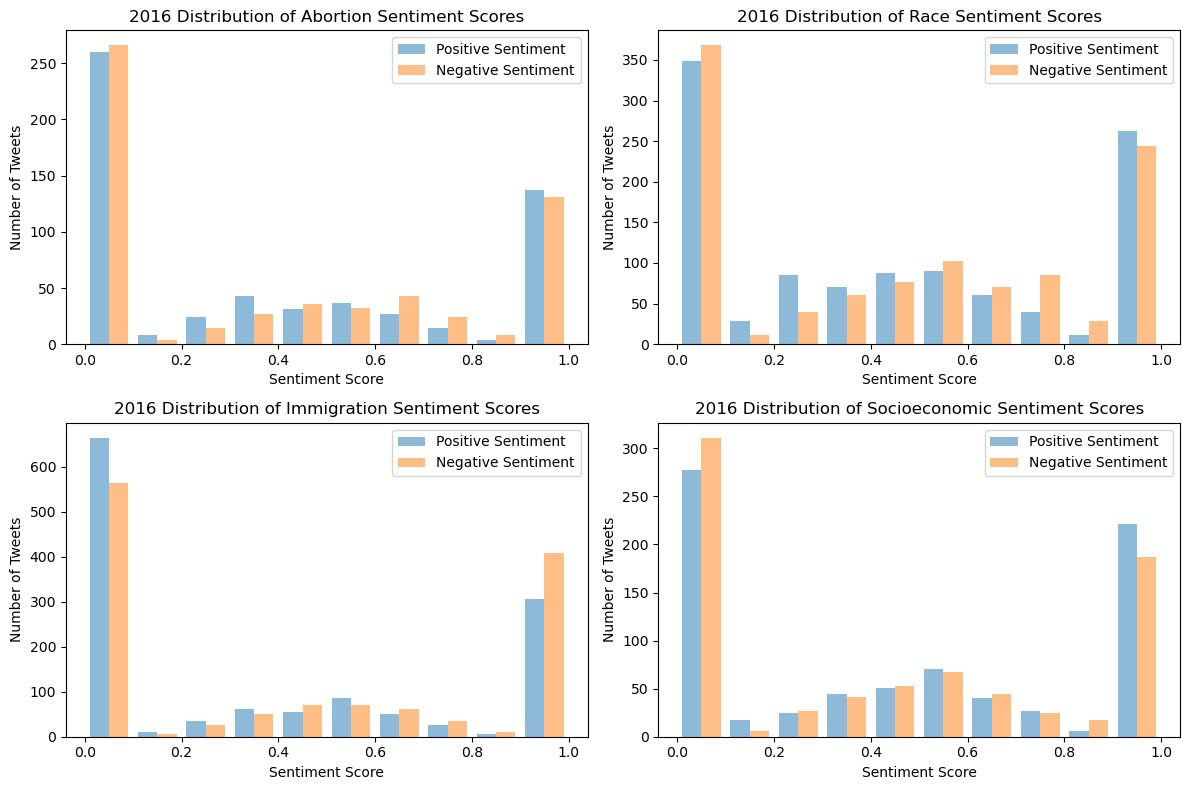

In [77]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot histogram for abortion sentiment
axes[0, 0].hist([abortion_sent_2016['Norm_Pos'], abortion_sent_2016['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[0, 0].set_xlabel('Sentiment Score')
axes[0, 0].set_ylabel('Number of Tweets')
axes[0, 0].set_title('2016 Distribution of Abortion Sentiment Scores')
axes[0, 0].legend()

# Plot histogram for race sentiment
axes[0, 1].hist([race_sent_2016['Norm_Pos'], race_sent_2016['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[0, 1].set_xlabel('Sentiment Score')
axes[0, 1].set_ylabel('Number of Tweets')
axes[0, 1].set_title('2016 Distribution of Race Sentiment Scores')
axes[0, 1].legend()

# Plot histogram for immigration sentiment
axes[1, 0].hist([immigration_sent_2016['Norm_Pos'], immigration_sent_2016['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[1, 0].set_xlabel('Sentiment Score')
axes[1, 0].set_ylabel('Number of Tweets')
axes[1, 0].set_title('2016 Distribution of Immigration Sentiment Scores')
axes[1, 0].legend()

# Plot histogram for socioeconomic sentiment
axes[1, 1].hist([socio_sent_2016['Norm_Pos'], socio_sent_2016['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[1, 1].set_xlabel('Sentiment Score')
axes[1, 1].set_ylabel('Number of Tweets')
axes[1, 1].set_title('2016 Distribution of Socioeconomic Sentiment Scores')
axes[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Creating one table with all Bias group tags

In [78]:
data_2016
# gives 8202 rows

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco
0,2016,2016-01-01 2:56:36,AL,245053853,richard shelby hold real ftd meeting with his ...,NaN,NaN,NaN,NaN
1,2016,2016-01-02 1:25:05,TX,4656434324,last election chance to rid america of the sco...,NaN,NaN,NaN,NaN
2,2016,2016-01-02 22:17:10,NV,3676940660,the superrich be spending incredible amount on...,NaN,NaN,NaN,NaN
3,2016,2016-01-03 10:33:49,TX,14649308,deep convos after midtown about black life mat...,NaN,black,NaN,NaN
4,2016,2016-01-04 6:59:14,MN,10207502,goldencreek268 respectfullyhow will a status q...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8370,2016,2016-11-29 5:25:46,CA,8395482,so youre say it be economic populism that won ...,NaN,white,nationalism,economic
8371,2016,2016-11-29 11:14:18,WY,57732182,dem narrative isnt work anywheregun controlsom...,NaN,NaN,NaN,NaN
8372,2016,2016-11-29 15:07:31,MA,755425,im old enough to remember when trump generalel...,NaN,NaN,NaN,NaN
8373,2016,2016-11-29 17:11:24,VA,126009130,seanhannity newtgingrich romney ryan couldnt w...,NaN,NaN,NaN,NaN


In [79]:
# Remove rows with all NaN values in 'Abortion', 'Race', 'Immigration', and 'Socio_Eco' columns
data_2016_filtered = data_2016.dropna(subset=['Abortion', 'Race', 'Immigration', 'Socio_Eco'], how='all')

# Display the filtered DataFrame
print(data_2016_filtered)


      Year              Created State      Owner   
3     2016  2016-01-03 10:33:49    TX   14649308  \
5     2016  2016-01-04 16:23:26    NH   88940328   
6     2016   2016-01-05 7:13:04    VA  359716229   
8     2016   2016-01-06 2:52:22    AZ   67238855   
9     2016  2016-01-06 15:27:19    NY   49698134   
...    ...                  ...   ...        ...   
8366  2016  2016-11-28 21:49:25    AZ   67238855   
8367  2016  2016-11-28 23:51:09    TX  408110696   
8369  2016   2016-11-29 3:58:07    CA   44526609   
8370  2016   2016-11-29 5:25:46    CA    8395482   
8374  2016  2016-11-29 17:33:46    CA   16753853   

                                                  Tweet  Abortion    Race   
3     deep convos after midtown about black life mat...       NaN   black  \
5     president bill clinton say this election will ...       NaN     NaN   
6     we need someone to videotape trump talk shit a...       NaN     NaN   
8     usatoday bo i hear you refer to electionobama ...       NaN  

In [80]:
# run Vader sentiment on All tweets
data_sent_2016 = get_sentiment_scores(data_2016_filtered)
data_sent_2016
# gives 3229 rows

C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\172291821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\172291821.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,SentimentScores
3,2016,2016-01-03 10:33:49,TX,14649308,deep convos after midtown about black life mat...,NaN,black,NaN,NaN,"{'neg': 0.26, 'pos': 0.073}"
5,2016,2016-01-04 16:23:26,NH,88940328,president bill clinton say this election will ...,NaN,NaN,NaN,middle,"{'neg': 0.0, 'pos': 0.136}"
6,2016,2016-01-05 7:13:04,VA,359716229,we need someone to videotape trump talk shit a...,NaN,NaN,NaN,middle,"{'neg': 0.243, 'pos': 0.092}"
8,2016,2016-01-06 2:52:22,AZ,67238855,usatoday bo i hear you refer to electionobama ...,NaN,NaN,immigration,NaN,"{'neg': 0.158, 'pos': 0.0}"
9,2016,2016-01-06 15:27:19,NY,49698134,sound like the gop establishment have decide t...,abortion,NaN,NaN,NaN,"{'neg': 0.0, 'pos': 0.128}"
...,...,...,...,...,...,...,...,...,...,...
8366,2016,2016-11-28 21:49:25,AZ,67238855,postpolitics bo i hear you refer to election i...,NaN,NaN,immigration,NaN,"{'neg': 0.158, 'pos': 0.0}"
8367,2016,2016-11-28 23:51:09,TX,408110696,so how do you steer kid in a first grade class...,NaN,racial,NaN,inequality,"{'neg': 0.107, 'pos': 0.0}"
8369,2016,2016-11-29 3:58:07,CA,44526609,bcappelbaum richardflorida russia hack million...,NaN,NaN,illegal,NaN,"{'neg': 0.275, 'pos': 0.0}"
8370,2016,2016-11-29 5:25:46,CA,8395482,so youre say it be economic populism that won ...,NaN,white,nationalism,economic,"{'neg': 0.0, 'pos': 0.179}"


In [81]:
# Extract the sentiment scores from the 'SentimentScores' column
data_sent_2016['Norm_Neg'] = data_sent_2016['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
data_sent_2016['Norm_Pos'] = data_sent_2016['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
data_sent_2016
# gives 3164 rows

C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\3628976065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sent_2016['Norm_Neg'] = data_sent_2016['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\3628976065.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sent_2016['Norm_Pos'] = data_sent_2016['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos'])

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,SentimentScores,Norm_Neg,Norm_Pos
3,2016,2016-01-03 10:33:49,TX,14649308,deep convos after midtown about black life mat...,NaN,black,NaN,NaN,"{'neg': 0.26, 'pos': 0.073}",0.780781,0.219219
5,2016,2016-01-04 16:23:26,NH,88940328,president bill clinton say this election will ...,NaN,NaN,NaN,middle,"{'neg': 0.0, 'pos': 0.136}",0.000000,1.000000
6,2016,2016-01-05 7:13:04,VA,359716229,we need someone to videotape trump talk shit a...,NaN,NaN,NaN,middle,"{'neg': 0.243, 'pos': 0.092}",0.725373,0.274627
8,2016,2016-01-06 2:52:22,AZ,67238855,usatoday bo i hear you refer to electionobama ...,NaN,NaN,immigration,NaN,"{'neg': 0.158, 'pos': 0.0}",1.000000,0.000000
9,2016,2016-01-06 15:27:19,NY,49698134,sound like the gop establishment have decide t...,abortion,NaN,NaN,NaN,"{'neg': 0.0, 'pos': 0.128}",0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
8366,2016,2016-11-28 21:49:25,AZ,67238855,postpolitics bo i hear you refer to election i...,NaN,NaN,immigration,NaN,"{'neg': 0.158, 'pos': 0.0}",1.000000,0.000000
8367,2016,2016-11-28 23:51:09,TX,408110696,so how do you steer kid in a first grade class...,NaN,racial,NaN,inequality,"{'neg': 0.107, 'pos': 0.0}",1.000000,0.000000
8369,2016,2016-11-29 3:58:07,CA,44526609,bcappelbaum richardflorida russia hack million...,NaN,NaN,illegal,NaN,"{'neg': 0.275, 'pos': 0.0}",1.000000,0.000000
8370,2016,2016-11-29 5:25:46,CA,8395482,so youre say it be economic populism that won ...,NaN,white,nationalism,economic,"{'neg': 0.0, 'pos': 0.179}",0.000000,1.000000


In [82]:
# This function only gets the compound sentiment
def get_compound_sentiment(df):
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
        # Create a new column for sentiment scores
    df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
    
    # Remove the 'neu' column from the SentimentScores column
    df['Compound'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu','pos','neg']})
    
    return df

In [83]:
# run Vader sentiment on All tweets
data_all_sent_2016 = get_compound_sentiment(data_2016_filtered)
# Drop Sentiment Scores column
data_all_sent_2016 = data_all_sent_2016.drop(['SentimentScores'], axis=1)
data_all_sent_2016
# gives 3164 rows

C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\406677615.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\406677615.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Compound'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu','pos','neg']})


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,Norm_Neg,Norm_Pos,Compound
3,2016,2016-01-03 10:33:49,TX,14649308,deep convos after midtown about black life mat...,NaN,black,NaN,NaN,0.780781,0.219219,{'compound': -0.5859}
5,2016,2016-01-04 16:23:26,NH,88940328,president bill clinton say this election will ...,NaN,NaN,NaN,middle,0.000000,1.000000,{'compound': 0.296}
6,2016,2016-01-05 7:13:04,VA,359716229,we need someone to videotape trump talk shit a...,NaN,NaN,NaN,middle,0.725373,0.274627,{'compound': -0.6204}
8,2016,2016-01-06 2:52:22,AZ,67238855,usatoday bo i hear you refer to electionobama ...,NaN,NaN,immigration,NaN,1.000000,0.000000,{'compound': -0.4939}
9,2016,2016-01-06 15:27:19,NY,49698134,sound like the gop establishment have decide t...,abortion,NaN,NaN,NaN,0.000000,1.000000,{'compound': 0.3612}
...,...,...,...,...,...,...,...,...,...,...,...,...
8366,2016,2016-11-28 21:49:25,AZ,67238855,postpolitics bo i hear you refer to election i...,NaN,NaN,immigration,NaN,1.000000,0.000000,{'compound': -0.4939}
8367,2016,2016-11-28 23:51:09,TX,408110696,so how do you steer kid in a first grade class...,NaN,racial,NaN,inequality,1.000000,0.000000,{'compound': -0.34}
8369,2016,2016-11-29 3:58:07,CA,44526609,bcappelbaum richardflorida russia hack million...,NaN,NaN,illegal,NaN,1.000000,0.000000,{'compound': -0.6486}
8370,2016,2016-11-29 5:25:46,CA,8395482,so youre say it be economic populism that won ...,NaN,white,nationalism,economic,0.000000,1.000000,{'compound': 0.5719}


## Final correct data frame to upload to postgresSQL

In [84]:
# Extract to compound value from the dictionary

# Update the "Compound" column
data_all_sent_2016['Compound'] = data_all_sent_2016['Compound'].apply(lambda x: x['compound'])

# Convert the "Compound" column to a numeric data type
data_all_sent_2016['Compound'] = pd.to_numeric(data_all_sent_2016['Compound'])

# Print the updated DataFrame
data_all_sent_2016
# gives 3164 rows by 12 columns

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,Norm_Neg,Norm_Pos,Compound
3,2016,2016-01-03 10:33:49,TX,14649308,deep convos after midtown about black life mat...,NaN,black,NaN,NaN,0.780781,0.219219,-0.5859
5,2016,2016-01-04 16:23:26,NH,88940328,president bill clinton say this election will ...,NaN,NaN,NaN,middle,0.000000,1.000000,0.2960
6,2016,2016-01-05 7:13:04,VA,359716229,we need someone to videotape trump talk shit a...,NaN,NaN,NaN,middle,0.725373,0.274627,-0.6204
8,2016,2016-01-06 2:52:22,AZ,67238855,usatoday bo i hear you refer to electionobama ...,NaN,NaN,immigration,NaN,1.000000,0.000000,-0.4939
9,2016,2016-01-06 15:27:19,NY,49698134,sound like the gop establishment have decide t...,abortion,NaN,NaN,NaN,0.000000,1.000000,0.3612
...,...,...,...,...,...,...,...,...,...,...,...,...
8366,2016,2016-11-28 21:49:25,AZ,67238855,postpolitics bo i hear you refer to election i...,NaN,NaN,immigration,NaN,1.000000,0.000000,-0.4939
8367,2016,2016-11-28 23:51:09,TX,408110696,so how do you steer kid in a first grade class...,NaN,racial,NaN,inequality,1.000000,0.000000,-0.3400
8369,2016,2016-11-29 3:58:07,CA,44526609,bcappelbaum richardflorida russia hack million...,NaN,NaN,illegal,NaN,1.000000,0.000000,-0.6486
8370,2016,2016-11-29 5:25:46,CA,8395482,so youre say it be economic populism that won ...,NaN,white,nationalism,economic,0.000000,1.000000,0.5719


In [187]:
# View non-NaN values from 'Abortion' column
abortion_values = data_2016[data_2016['Abortion'].notna()]['Abortion']
print(abortion_values)

# View non-NaN values from 'Race' column
race_values = data_2016[data_2016['Race'].notna()]['Race']
print(race_values)

# View non-NaN values from 'Immigration' column
immigration_values = data_2016[data_2016['Immigration'].notna()]['Immigration']
print(immigration_values)

# View non-NaN values from 'Socio_Eco' column
socioeco_values = data_2016[data_2016['Socio_Eco'].notna()]['Socio_Eco']
print(socioeco_values)


9           abortion
16           prolife
41      reproductive
47               ban
53          abortion
            ...     
8294        abortion
8300          debate
8302      healthcare
8305           right
8307        abortion
Name: Abortion, Length: 680, dtype: object
3        black
15       white
19       civil
57      racial
59       white
         ...  
8343     white
8351     white
8352    racial
8367    racial
8370     white
Name: Race, Length: 1087, dtype: object
8       immigration
13      immigration
14      immigration
21           border
34          illegal
           ...     
8359      sanctuary
8365     xenophobia
8366    immigration
8369        illegal
8370    nationalism
Name: Immigration, Length: 1304, dtype: object
5           middle
6           middle
17        medicare
28           class
68        security
           ...    
8327         class
8330      security
8367    inequality
8370      economic
8374       poverty
Name: Socio_Eco, Length: 778, dtype: object


# Load Sentiments into PostGres
abortion_sent_2016  
race_sent_2016  
immigration_sent_2016  
socio_sent_2016  
data_sent_2016  

data_all_sent_2016: The single table that has all data

In [ ]:
# create db in postgres: c\ sentiment;

# build tables
# 	Year	Time	State	User	Tweet	Socio_Eco	SentimentScores
# Year	Time	State	User	Tweet	Abortion	Race	Immigration	Socio_Eco	SentimentScores	Norm_Neg	Norm_Pos

# CREATE TABLE twitter (
#     Year INTEGER,
#     Created TIMESTAMP,
#     State VARCHAR(2),
#     Owner VARCHAR(255),
#     Tweet TEXT,
#     Abortion VARCHAR(255),
#     Race VARCHAR(255),
#     Immigration VARCHAR(255),
#     Socio_Eco VARCHAR(255),
#     Norm_neg FLOAT,
#     Norm_pos FLOAT,
#     Compound FLOAT
# );

# # view all tables: \dt
# SELECT * FROM twitter;

# Individual tables
# Upload the data frames to the database using the results table
# abortion_sent_2016.to_sql("twitter", engine, if_exists="replace", index=False)
# race_sent_2016.to_sql("twitter", engine, if_exists="append", index=False)
# immigration_sent_2016.to_sql("twitter", engine, if_exists="append", index=False)
# socio_sent_2016.to_sql("twitter", engine, if_exists="append", index=False)


In [85]:
# Replace the values below with your database credentials
DATABASE = "sentimentdb"
USER = "postgres"
PASSWORD = "YourPassword"
HOST = "localhost"
PORT = "5432"

# Connect to your PostgreSQL database
conn = psycopg2.connect(
    database=DATABASE,
    user=USER,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

# Create a sqlalchemy engine
engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}")

data_all_sent_2016.to_sql("twitter", engine, if_exists="replace", index=False)
print("Twitter table loaded successfully")

# Commit the changes to the database
conn.commit()

# Close the database connection
conn.close()

Twitter table loaded successfully


## View the data

In [86]:
# Replace the values below with your database credentials
DATABASE = "sentimentdb"
USER = "postgres"
PASSWORD = "YourPassword"
HOST = "localhost"
PORT = "5432"

# Connect to the PostgreSQL database
conn = psycopg2.connect(database=DATABASE, user=USER, password=PASSWORD, host=HOST, port=PORT)

# Query the table and store the results in a Pandas dataframe
df = pd.read_sql_query("SELECT * FROM twitter", conn)

# Print the dataframe to verify that it contains data
print(df)

# Close the database connection
conn.close()
# gives [3164 rows x 12 columns] for 2016

      Year              Created State      Owner   
0     2016  2016-01-03 10:33:49    TX   14649308  \
1     2016  2016-01-04 16:23:26    NH   88940328   
2     2016   2016-01-05 7:13:04    VA  359716229   
3     2016   2016-01-06 2:52:22    AZ   67238855   
4     2016  2016-01-06 15:27:19    NY   49698134   
...    ...                  ...   ...        ...   
3159  2016  2016-11-28 21:49:25    AZ   67238855   
3160  2016  2016-11-28 23:51:09    TX  408110696   
3161  2016   2016-11-29 3:58:07    CA   44526609   
3162  2016   2016-11-29 5:25:46    CA    8395482   
3163  2016  2016-11-29 17:33:46    CA   16753853   

                                                  Tweet  Abortion    Race   
0     deep convos after midtown about black life mat...      None   black  \
1     president bill clinton say this election will ...      None    None   
2     we need someone to videotape trump talk shit a...      None    None   
3     usatoday bo i hear you refer to electionobama ...      None  

C:\Users\Owner\AppData\Local\Temp\ipykernel_26064\3988758511.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM twitter", conn)
